# Directed functional/effective network inference with linear methods

## Preliminaries

This notebook requires the following python libraries to be installed for your environment:
1. The usual suspects: `numpy`, `scipy`, `matplotlib`, `os`
2. The `stocks` data set requires `yfinance` and `pandas`

## Introduction

In this activity, we use linear methods to infer functional and effective connectivity, choosing between the following data sets:
1. Synthetic VAR dynamics on a Watts-Strogatz small world network
2. Stock market closing prices from the NYSE
3. fMRI recording of a movie watching task

Select which data set to use via the `dataSet` variable below.
Then, running the following code cell will read in or generate the data and make a carpet plot of it.

Generated data with 1000 time steps for 100 variables


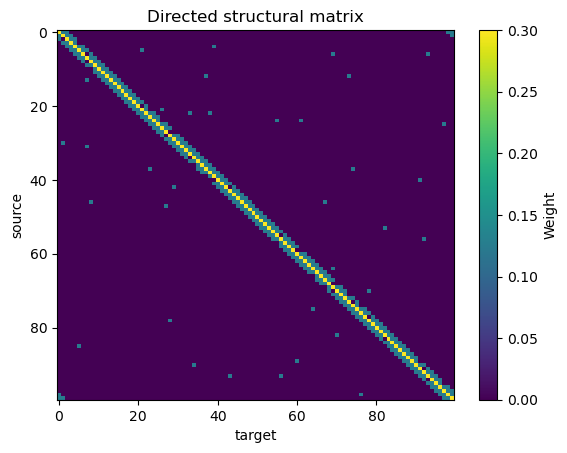

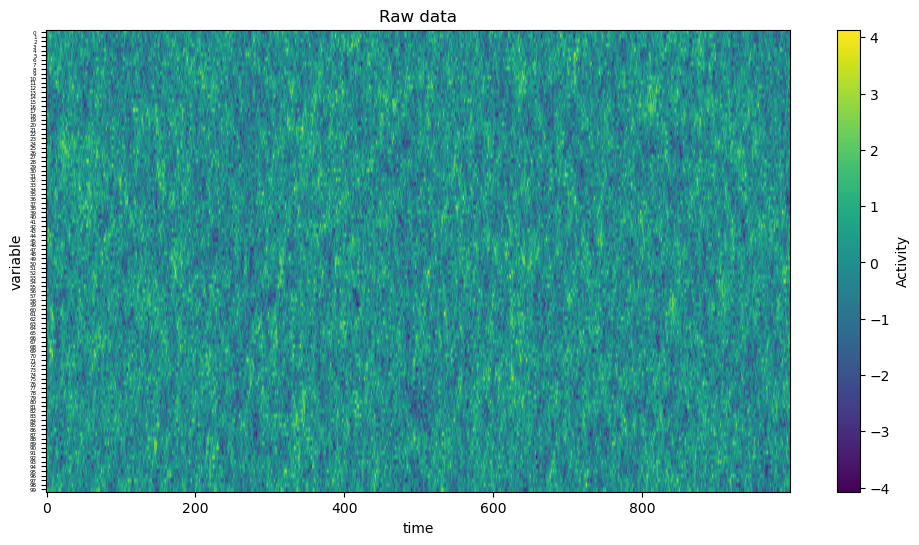

In [1]:
import numpy as np
import scipy.io
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mplcolors
import os

# Data set choices: 'sytheticVAR', 'fmri_movie', 'stocks' (and maybe 'mouse')
dataSet = 'syntheticVAR';

# Processing choices:
normalise = True
clusterFC = 'auto' # can be True, False or auto
labelfontsize = 4

# Load/prepare the data:
if (dataSet == 'syntheticVAR'):
    # Generate some VAR data run on a Watts-Strogatz ring network with d=4, p=0.1, self-weights=0.3, cross-weights=0.125
    matContents = scipy.io.loadmat('data/ws_ring_C.mat')
    C = np.array(matContents['C']); # C[i,j] is the connection from i to j, so we use row vectors here
    plt.figure()
    plt.imshow(C, aspect='auto')
    plt.xlabel('target');
    plt.ylabel('source');
    plt.title('Directed structural matrix');
    cbar = plt.colorbar()
    cbar.set_label('Weight');
    
    # Generate some time series data on this network:
    N = 100  # Number of variables
    S = 1000   # Number of time-series samples -- you can add more and watch accuracy increase
    initialTimeSteps = 10  # Warm-up steps
    # Initialize row vector X with standard normal values
    X = np.random.normal(0, 1, (1, N))
    # Initialize matrix to store samples
    data = np.zeros((S, N))
    sampleNum = 0
    for t in range(initialTimeSteps + S):
        newX = X @ C + np.random.normal(0, 1, (1, N))
        if t >= initialTimeSteps:
            data[sampleNum, :] = newX
            sampleNum += 1
        X = newX
    labels = np.arange(data.shape[1])
    if (clusterFC == 'auto'):
        clusterFC = False;
    dataMethod = 'Generated';
elif (dataSet == 'stocks'):
    stocksFile = 'data/stockClosingPricesData.npy';
    labelsFile = 'data/stockClosingPricesLabels.npy';
    if (os.path.exists(stocksFile)):
        print('Found stocks file');
        data = np.load(stocksFile);
        labels = np.load(labelsFile);
    else:
        print('Downloading NYSE stock closing prices');
        import yfinance as yf
        import pandas as pd
        # Define list of NYSE ticker symbols
        with open('data/SandP100.txt', 'r') as file:
            tickers = file.read().splitlines()
        # Download historical data from 2000 to today
        fullData = yf.download(tickers, start="2000-01-01", auto_adjust=True)
        # Keep only stocks with data available on all trading days:
        fullData = fullData.dropna(axis='columns')
        close_prices = fullData['Close']
        # data = close_prices.dropna(axis=1, how='any')
        # Alternatively, fill the nans with previous day's price:
        # data = close_prices.ffill()
        data = close_prices # All bad data already removed
        # Following doesn't work, fix later
        # tickers = fullData['Tickers'] # Grab tickers for the final data only
        data = np.array(data)
        # print('Before log-differences %d samples for %d variables' % (data.shape[0], data.shape[1]))
        # And take log differences:
        data = np.log(data[1:,:]) - np.log(data[:-1,:])
        labels = np.array(fullData.Close.keys());
        np.save(stocksFile, data)
        np.save(labelsFile, labels)
    if (clusterFC == 'auto'):
        clusterFC = True;
    dataMethod = 'Read in';
elif (dataSet == 'fmri_movie'):
    # Downloaded from nilearn's fetch_atlas_msdl dataset under 
    data = np.load('data/development_fmri_msdl_subject1.npy');
    labels = np.load('data/development_fmri_msdl_roiLabels.npy');
    if (clusterFC == 'auto'):
        clusterFC = False;
    labelfontsize = 6;
    dataMethod = 'Read in';
# elif (dataSet == 'mouse'):
#    # TODO: need permission to distribute preprocessed data here or add code to process:
#    matContents = scipy.io.loadmat('data/18MicefMRISubset.mat')
#    # As numpy array:
#    timeSeries = np.array(matContents['timeSeries']);
#    data = timeSeries[:,:,1].T # We want time as first index, variable as second
#    labels = np.arange(data.shape[1]) # Add these later
#    if (clusterFC == 'auto'):
#        clusterFC = False;
#    dataMethod = 'Read in';
else:
    raise SystemExit('Invalid dataSet %s' % dataSet)

timeSteps = data.shape[0]
networkSize = data.shape[1]
print('%s data with %d time steps for %d variables' % (dataMethod, data.shape[0], data.shape[1]))

# Normalise the data?
if (normalise):
    data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
# Check: print(np.mean(data, axis=0))
if (clusterFC):
    clusterSuffix = ' clustered'
else:
    clusterSuffix = ''

# Make a carpet plot of the raw data:
plt.figure(figsize=(12,6))
plt.imshow(data.T, aspect='auto')
plt.xlabel('time');
plt.ylabel('variable');
plt.yticks(ticks=np.arange(len(labels)), labels=labels, fontsize=labelfontsize)
plt.title('Raw data');
cbar = plt.colorbar()
cbar.set_label('Activity');
if (dataSet == 'stocks'):
    plt.clim(-3,3);

## A. Compute functional connectivity

First we will infer the functional network to represent the pairwise statistical relationships between the variables as the nodes in our network. We'll use correlation for these discrete valued variables.

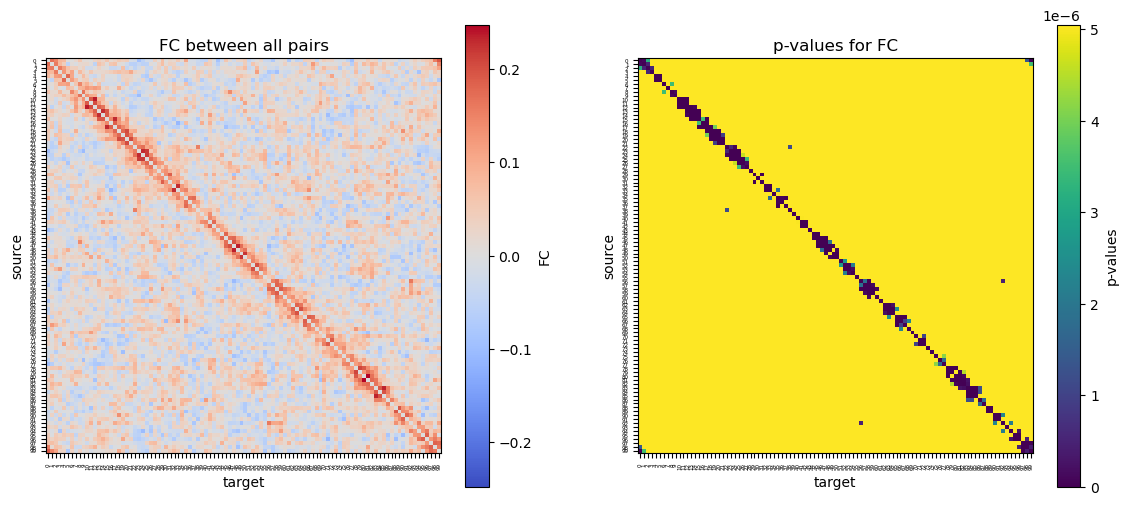

In [2]:
fc = np.zeros((networkSize,networkSize));
pValues = np.zeros((networkSize,networkSize));

# Here in principle we could use corrcoef(data, rowvar=False) however this does not provide statistical significance calculations.
# So instead we loop over calls to scipy.pearsonr:
for s in range(networkSize):
    for t in range(networkSize):
        # For each source-dest pair:
        if (s == t):
            continue
        # We could compute only once for each pair, but leave the loop in case we do an undirected measure later:
        fc[s,t], pValues[s,t] = stats.pearsonr(data[:,s],data[:,t])

if (clusterFC):
    from scipy.cluster.hierarchy import linkage, optimal_leaf_ordering, leaves_list
    from scipy.spatial.distance import pdist
    # Perform hierarchical clustering using average linkage
    distances = np.max(fc) - fc
    Z = linkage(distances, method='average')
    # Compute the optimal leaf ordering
    optimal_Z = optimal_leaf_ordering(Z, distances)
    # Get the order of the leaves
    optimal_order = leaves_list(optimal_Z)
else:
    optimal_order = np.arange(networkSize); # won't change anything

# Plot the FC:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1) # left subplot
plt.imshow(fc[optimal_order,:][:,optimal_order],cmap=cm.coolwarm, norm=mplcolors.CenteredNorm())
plt.xlabel('target');
plt.xticks(ticks=np.arange(len(labels)), labels=labels[optimal_order], rotation=90, fontsize=labelfontsize)
plt.ylabel('source');
plt.yticks(ticks=np.arange(len(labels)), labels=labels[optimal_order], fontsize=labelfontsize)
plt.title('FC between all pairs%s' % clusterSuffix);
cbar = plt.colorbar()
cbar.set_label('FC');
plt.subplot(1,2,2) # right subplot
plt.imshow(pValues[optimal_order, :][:, optimal_order])
plt.xlabel('target');
plt.xticks(ticks=np.arange(len(labels)), labels=labels[optimal_order], rotation=90, fontsize=labelfontsize)
plt.ylabel('source');
plt.yticks(ticks=np.arange(len(labels)), labels=labels[optimal_order], fontsize=labelfontsize)
plt.title('p-values for FC%s' % clusterSuffix);
cbar = plt.colorbar()
cbar.set_label('p-values');
plt.clim(0,0.05/(networkSize*(networkSize-1))); # Can use this to highlight significant p-values

Look at the results for the adjacency matrix for the functional network on the left figure above:
* What do you observe in terms of the functional network structure? Is there stucture as to which sources have the highest MI to each target? (you could try setting `clusterFC=True` in the first code block if anhy clustering is not clear.
* For the other data sets, are the strongly related nodes sensible pairings (in terms of neural / financial knowledge)?
* If using the synthetic data set, how does it compare to what you know the underlying causal structure to be? Is that what you expected to see?

_Challenge_: try to correct for the autocorrelations in these samples using Oliver Cliff's [assessing-linear-dependence](https://github.com/olivercliff/assessing-linear-dependence) code

## B. Directed functional network inference with Transfer Entropy (TE)

Next we compute directed pairwise statistical relationships in the network via the lagged covariance matrix (it remains a lagged correlation, or close enough if you left `normalise = True` in the first code block). 

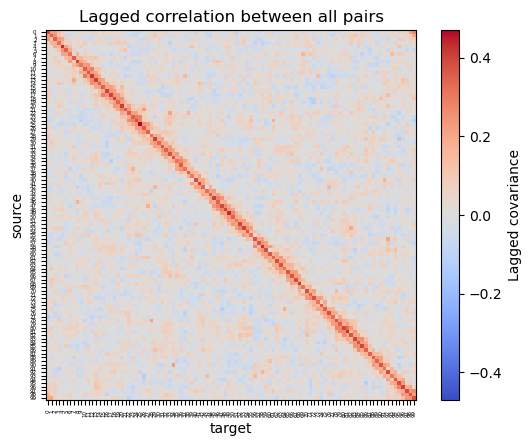

In [3]:
# Contemporaneous covariance (compute now since we'll need it later anyway)
cov = np.cov(data, rowvar=False) # Will match the correlation above given we've normalised, except for the diagonal
# Lag 1 covariance, between time step before and time step after:
cov_lag1 = np.dot(data[:-1,:].T, data[1:,:]) / (timeSteps - 1)

plt.imshow(cov_lag1[optimal_order, :][:, optimal_order],cmap=cm.coolwarm, norm=mplcolors.CenteredNorm())
plt.xlabel('target');
plt.xticks(ticks=np.arange(len(labels)), labels=labels[optimal_order], rotation=90, fontsize=labelfontsize)
plt.ylabel('source');
plt.yticks(ticks=np.arange(len(labels)), labels=labels[optimal_order], fontsize=labelfontsize)
plt.title('Lagged correlation between all pairs%s' % clusterSuffix);
cbar = plt.colorbar()
cbar.set_label('Lagged covariance');

_Challenge_: adapt the code for lagged correlation to return p-values for each pair (you'll need to replace the single line calculation with loops like for correlation), and plot these like for correlation.
_Further challenge_: use the [assessing-linear-dependence](https://github.com/olivercliff/assessing-linear-dependence) code as above to control for autocorrelations here.

## C. Effective network inference with least squares regression

Finally, we'll construct effective connectivity via a least squares regression applied to the data.

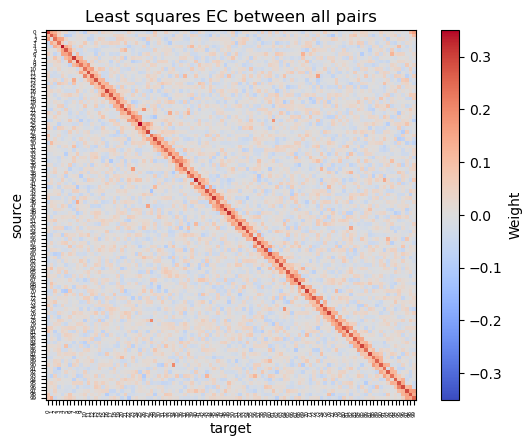

In [4]:
# Now invert: cov_lag1 = cov * C in our notation, so
# C = cov^-1 * cov_lag1
inferredC = np.linalg.inv(cov) @ cov_lag1;

if (dataSet == 'synthetic'):
    # We have a ground truth so we'll plot that as well. Make preparations here:
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1) # left subplot
plt.imshow(inferredC[optimal_order, :][:, optimal_order], cmap=cm.coolwarm, norm=mplcolors.CenteredNorm())
plt.xlabel('target');
plt.xticks(ticks=np.arange(len(labels)), labels=labels[optimal_order], rotation=90, fontsize=4)
plt.ylabel('source');
plt.yticks(ticks=np.arange(len(labels)), labels=labels[optimal_order], fontsize=4)
plt.title('Least squares EC between all pairs%s' % clusterSuffix);
cbar = plt.colorbar()
cbar.set_label('Weight');
if (dataSet == 'synthetic'):
    # We have a ground truth so we'll plot that as well:
    plt.subplot(1,2,2) # right subplot
    plt.imshow(C[optimal_order, :][:, optimal_order])
    plt.xlabel('target');
    plt.xticks(ticks=np.arange(len(labels)), labels=labels[optimal_order], rotation=90, fontsize=labelfontsize)
    plt.ylabel('source');
    plt.yticks(ticks=np.arange(len(labels)), labels=labels[optimal_order], fontsize=labelfontsize)
    plt.title('Directed structural matrix%s' % clusterSuffix);
    cbar = plt.colorbar()
    cbar.set_label('Weight');

Reflect:
* How do the results compare to your expectation?
* If you're using the synthetic network, how might you separate what is a true connection from a spurious one here? Do the results improve as we use more time samples (you can change this in the first code block)?
* For the other data sets, how might we improve our results (e.g. more time samples, more subjects to combine across, other methods ...)?